In [66]:
import google.datalab.bigquery as bq
from google.datalab.storage import Bucket

import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Extract design A data from BigQuery
%%bq query -n design_a
SELECT page, timestamp
FROM `user_log_dataset.weblog`
WHERE timestamp BETWEEN '2021-11-11 00:00:01' AND '2021-11-30 23:59:59'

In [8]:
%%bq sample --count 5 --query design_a

page,timestamp
/,2021-11-17 09:24:37
/gadget/004,2021-11-30 01:46:23
/,2021-11-11 04:09:40
/special,2021-11-27 17:12:38
/special,2021-11-23 10:48:14


In [9]:
design_a_df = design_a.execute(output_options=bq.QueryOutput.dataframe()).result()

In [10]:
design_a_df.head()

,page,timestamp
0,/,2021-11-17 09:24:37
1,/gadget/004,2021-11-30 01:46:23
2,/,2021-11-11 04:09:40
3,/special,2021-11-27 17:12:38
4,/special,2021-11-23 10:48:14


In [20]:
# Extract design B data from BigQuery
%%bq query -n design_b
SELECT page, timestamp
FROM `user_log_dataset.weblog`
WHERE timestamp BETWEEN '2021-12-01 00:00:01' AND '2021-12-21 23:59:59'

In [21]:
%%bq sample --count 5 --query design_b

page,timestamp
/,2021-12-04 04:37:44
/special,2021-12-19 15:19:25
/,2021-12-06 05:36:15
/special,2021-12-12 19:53:20
/books/002,2021-12-09 04:27:33


In [22]:
design_b_df = design_b.execute(output_options=bq.QueryOutput.dataframe()).result()

In [24]:
design_b_df.head()

,page,timestamp
0,/,2021-12-04 04:37:44
1,/special,2021-12-19 15:19:25
2,/,2021-12-06 05:36:15
3,/special,2021-12-12 19:53:20
4,/books/002,2021-12-09 04:27:33


In [60]:
a_groupby = design_a_df.groupby('page').count()
a_groupby

,timestamp
page,
/,234
/books,26
/books/001,14
/books/002,10
/gadget,24
/gadget/004,23
/special,89
/special/thankyou,52


In [61]:
b_groupby = design_b_df.groupby('page').count()
b_groupby

,timestamp
page,
/,222
/books,22
/books/001,13
/books/002,15
/gadget,15
/gadget/004,24
/special,81
/special/thankyou,59


In [59]:
total_visitor_a = a_groupby.loc[['/special']].values[0][0]
a_conversion = a_groupby.loc[['/special/thankyou']].values[0][0]
total_visitor_b = b_groupby.loc[['/special']].values[0][0]
b_conversion = b_groupby.loc[['/special/thankyou']].values[0][0]

# If samples = N and conversion = X, then X follows a binomial distribution. 
# If we choose beta distribution for the prior, the posterior will also be beta distribution too
# The Posterior beta distribution will be Beta(alpha + X, beta + N - X)
alpha_prior = 1
beta_prior = 1

posterior_a = scipy.stats.beta(alpha_prior + total_visitor_a, beta_prior + total_visitor_a - a_conversion)
posterior_b = scipy.stats.beta(alpha_prior + total_visitor_b, beta_prior + total_visitor_b - b_conversion)

samples = 20000
samples_posterior_a = posterior_a.rvs(samples)
samples_posterior_b = posterior_b.rvs(samples)

prob = (samples_posterior_a < samples_posterior_b).mean()
print(prob)

0.91575


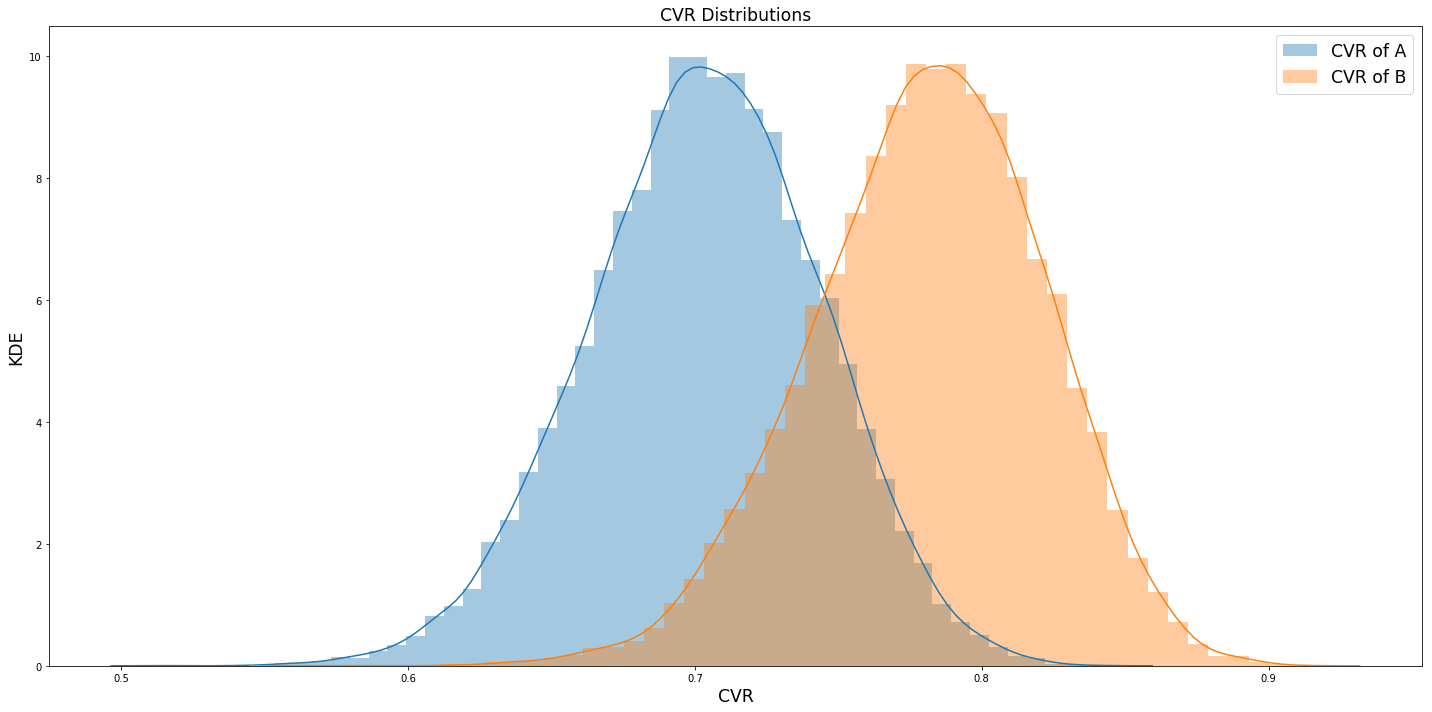

In [58]:
# Graph setting
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
sns.distplot(samples_posterior_a, ax=ax, label='CVR of A')
sns.distplot(samples_posterior_b, ax=ax, label='CVR of B')
ax.set_ylabel('KDE', fontsize='xx-large')
ax.set_xlabel('CVR', fontsize='xx-large')
ax.set_title('CVR Distributions', fontsize='xx-large')
ax.legend(loc='upper right', fontsize='xx-large')
fig.tight_layout()

In [63]:
# Export the processed data to Google Storage
data = [[total_visitor_a, total_visitor_b], [a_conversion, b_conversion]]
index_name = ['total', 'conversion']
col_name = ['design_a', 'design_b']

export_data = pd.DataFrame(data, index_name, col_name)

In [64]:
export_data

,design_a,design_b
total,89,52
conversion,81,59


In [67]:
export_data.to_csv('conversion.csv')

In [69]:
# Copy the file to Google Storage
!gsutil cp 'conversion.csv' gs://YOUR_BUCKET



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://conversion.csv [Content-Type=text/csv]...
/ [1 files][   48.0 B/   48.0 B]                                                
Operation completed over 1 objects/48.0 B.                                       
